We evaluate the hyperparameters for WalkSAT tested on 100 NAE instances.

In [2]:
import os
import sys
import warnings
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
warnings.filterwarnings('ignore')

In [3]:
import h5py
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
parent_dir = os.path.dirname(os.getcwd())
dir = f"{parent_dir}/experiments/exp4"

We extract the date and combine into one dataframe.

In [66]:
def tiebreak(filename):
	return filename.split("_")[1]

def k_val(filename):
	return int(filename.split("_")[2])

def hyperparameters(filename, tb):
	p = float(filename.split("_")[3].replace(".hdf5", ""))
	w1 = None
	w2 = None
	if tb == 'm2' or tb == 'm2b2':
		w1 = round(float(filename.split("_")[4]), 3)
		w2 = round(float(filename.split("_")[5].replace(".hdf5", "")), 3)
	return p, w1, w2

def get_median_mean(filepath):
	with h5py.File(filepath, "r") as f:
		tensor = f["times"][()]
		return np.median(tensor), np.mean(tensor)

# Create an empty Pandas dataframe with the desired columns
columns = ["k", "tiebreak", "p", "w1", "w2", "median", "mean"]
df = pd.DataFrame(columns=columns)

# Loop through all the HDF5 files in the directory and add their data to the dataframe
for filepath in glob.glob(f'{dir}/grid_search_results/rt_*.hdf5'):
	filename = filepath.split("/")[-1]
	tb = tiebreak(filename)
	k = k_val(filename)
	p, w1, w2 = hyperparameters(filename, tb)
	if p > 0:
		median, mean = get_median_mean(filepath)
		df = df.append({"k": k, "tiebreak": tb, "p": p, "w1": w1, "w2": w2, "median": median, "mean": mean}, ignore_index=True)


In [67]:
df

,k,tiebreak,p,w1,w2,median,mean
0,10,m2,0.05,0.2,0.8,4.0,9.90
1,4,m2,0.40,0.3,0.7,3.0,3.86
2,10,m2,0.95,0.9,0.1,5.0,6.92
3,7,m2,0.60,0.6,0.4,4.5,5.88
4,10,b,0.35,None,None,5.0,7.24
...,...,...,...,...,...,...,...
3835,6,m2,0.40,0.0,1.0,4.0,4.64
3836,7,m2,0.40,0.0,1.0,4.0,5.53
3837,3,m2b2,0.25,1.0,0.0,3.0,3.59
3838,10,b,0.45,None,None,4.0,5.64


In [68]:
min_median = df.groupby(['tiebreak', 'k'])['median'].transform('min')
lowest_median_combinations = df[df['median'] == min_median]
lowest_median_combinations = lowest_median_combinations[['tiebreak', 'k', 'p', 'w1', 'w2', 'median']]
lowest_median_combinations = lowest_median_combinations.sort_values(['tiebreak', 'k'])
print(lowest_median_combinations)

     tiebreak   k     p    w1    w2  median
236         b   3  0.05  None  None     3.0
640         b   3  0.65  None  None     3.0
657         b   3  0.75  None  None     3.0
759         b   3  0.90  None  None     3.0
969         b   3  0.40  None  None     3.0
...       ...  ..   ...   ...   ...     ...
1079     m2b2   7  0.65   1.0   0.0     3.5
1776     m2b2   7  0.05   0.6   0.4     3.5
799      m2b2   8  0.40   0.4   0.6     3.0
3150     m2b2   9  0.05   0.7   0.3     3.0
876      m2b2  10  0.25   0.3   0.7     3.0

[830 rows x 6 columns]


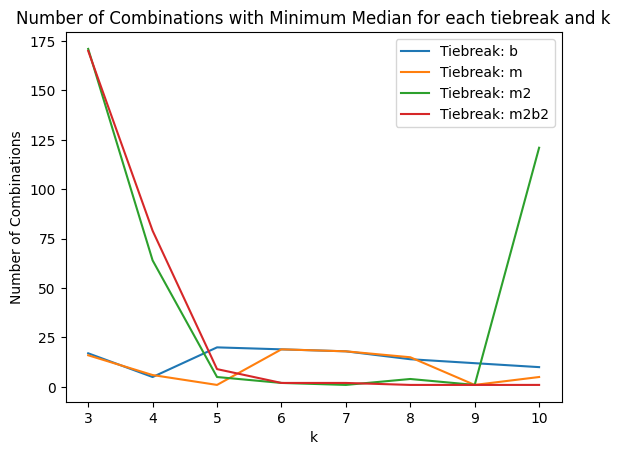

In [69]:
import matplotlib.pyplot as plt

# Count the number of combinations with the minimum median for each tiebreak and k
num_combinations = lowest_median_combinations.groupby(['tiebreak', 'k']).size()

# Iterate over each tiebreak type
for tiebreak in num_combinations.index.get_level_values('tiebreak').unique():
    tiebreak_combinations = num_combinations.loc[tiebreak]
    # Plot the graph for the tiebreak type
    plt.plot(tiebreak_combinations.index, tiebreak_combinations.values, label=f'Tiebreak: {tiebreak}')

# Set the plot labels and title
plt.xlabel('k')
plt.ylabel('Number of Combinations')
plt.title('Number of Combinations with Minimum Median for each tiebreak and k')

plt.legend()
plt.show()


We analyse the dependence on noise.

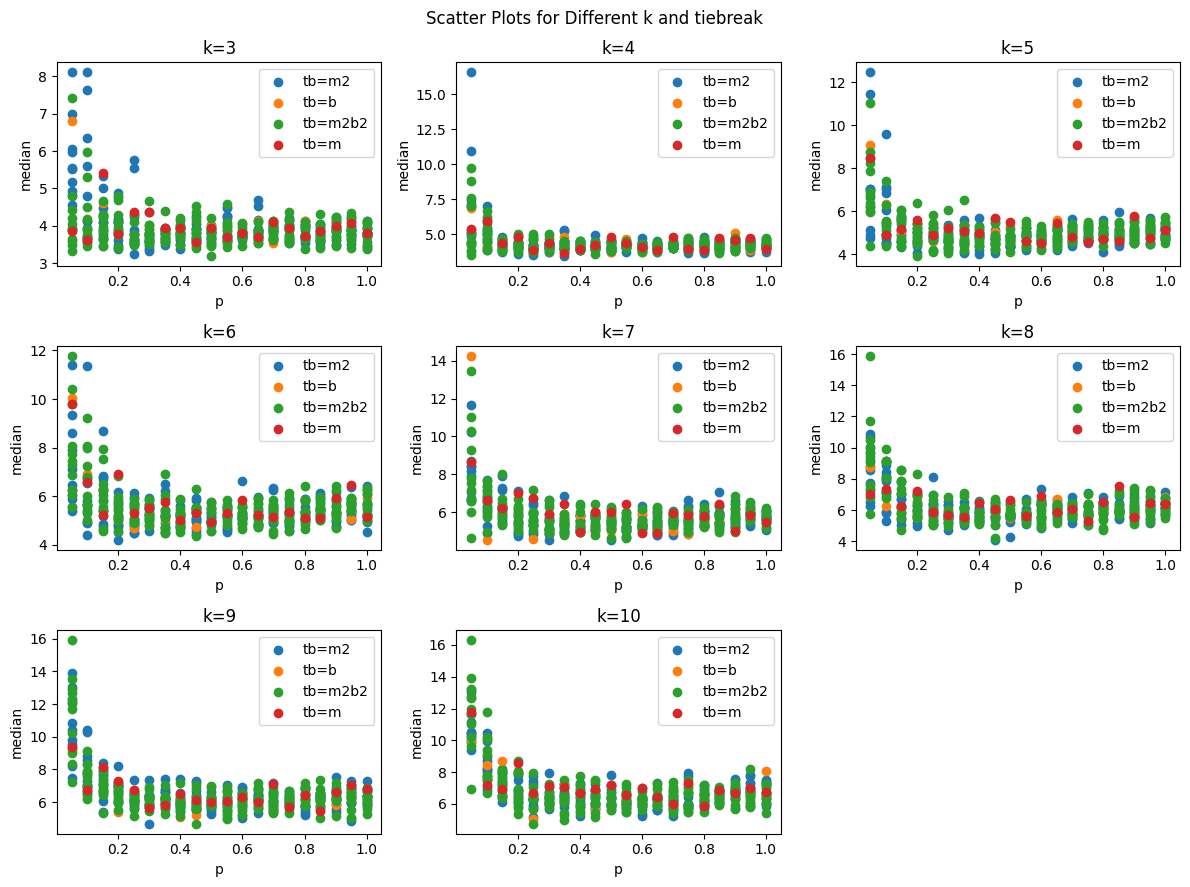

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique tiebreak values
tiebreak_values = df['tiebreak'].unique()

# Group the data by k
grouped = df.groupby('k')

num_plots = len(grouped)
num_cols = 3  # Number of columns in the subplot grid
num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 9))
fig.suptitle('Scatter Plots for Different k and tiebreak')

# Flatten the axes array to simplify indexing
axes = axes.flatten()

for i, (k, group_k) in enumerate(grouped):
    ax = axes[i]  # Select the current subplot
    ax.set_title(f"k={k}")
    
    for j, tb in enumerate(tiebreak_values):
        group_tb = group_k[group_k['tiebreak'] == tb]
        
        if len(group_tb) > 0:
            p_values = group_tb['p']
            mean_values = group_tb['mean']
            ax.scatter(p_values, mean_values, label=f"tb={tb}")
    
    ax.set_xlabel('p')
    ax.set_ylabel('median')
    ax.legend()

# Hide unused subplots, if any
for i in range(len(grouped), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [72]:
lowest_median_combinations.to_pickle(f'{dir}/params')

Decision:

Randomly sample parameters from combinations that result in minimum median running time.

We evaluate Walksatlm for each value of $k$:

In [8]:
import torch
import h5py
# Load, combine and calculate median running time from hdf5 files
num_proc = 10
batch_size = 250
ks = [i for i in range(3, 11)]
ns = [i for i in range(12, 21)]
tbs = ['m', 'b', 'm2', 'm2b2']

mrts = {}
for k in ks:
	mrts[k] = {}
	for n in ns:
		mrts[k][n] = {}
		for tb in tbs:
			# Initialise empty tensor for runtimes
			rt = torch.zeros(size=(num_proc * batch_size, ))
			for proc in range(num_proc):
				index = proc * batch_size
				filename = f'{dir}/results/rt_{n}_{k}_{tb}_{index}.hdf5' 
				with h5py.File(filename, 'r') as file:
					fresh = torch.from_numpy(file.get('times')[:])
					rt[index : index + batch_size] = fresh
			mrts[k][n][tb] = torch.median(rt)

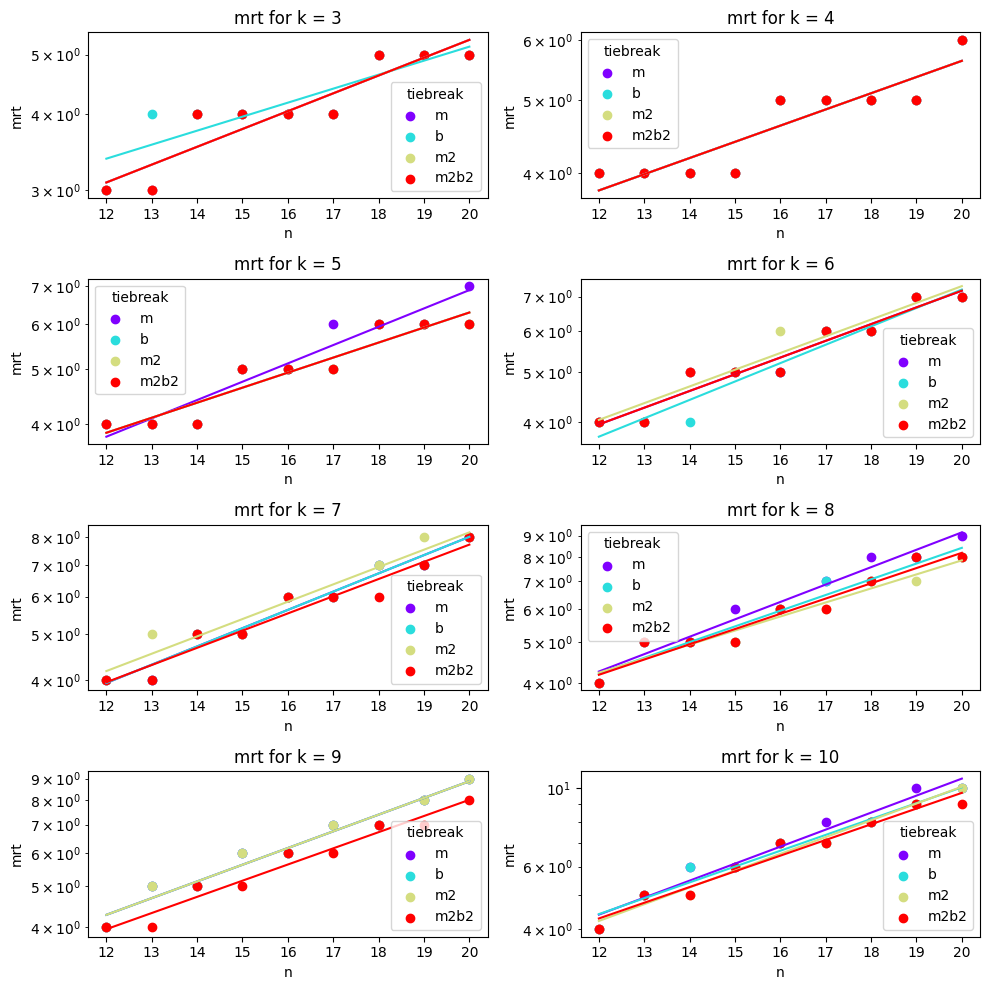

In [12]:
columns = 2
fig, axs = plt.subplots(len(ks) // columns, columns, figsize=(10, 10))
for (ax, k) in zip(axs.flatten(), ks):
	mrt = mrts[k]

	x = list(mrt.keys())
	ys = [[mrt[n][tb] for n in x] for tb in tbs]
	color = iter(plt.cm.rainbow(np.linspace(0, 1, len(tbs))))

	for (tb, y) in zip(tbs, ys):
		c = next(color)
		# Points
		ax.scatter(x, y, label=tb, color=c)

		# Line of best fit
		coefficients = np.polyfit(x, np.log(y), 1)
		polynomial = np.poly1d(coefficients)
		#print(polynomial)
		ax.plot(x, np.exp(polynomial(x)), color=c)

	ax.set_yscale('log')
	ax.set_xlabel('n')
	ax.set_ylabel('mrt')
	ax.legend(title='tiebreak')
	ax.set_title(f'mrt for k = {k}')

fig.tight_layout()
plt.show()

Compare m2b2 to $p=16$ QAOA:

In [59]:
import json
# Coefficients for QAOA
with open(f'{parent_dir}/experiments/exp3/results/coeffs.json', 'r') as f:
    qaoa_coeffs = json.load(f)
    qaoa_coeffs = {int(k) : {int(p) : c for (p, c) in coeffs.items()} for (k, coeffs) in qaoa_coeffs.items()}

In [51]:
# Only consider subset of parameters
ks = [i for i in range(3, 11)]
tbs = ['m2b2']
ps = [8, 16]

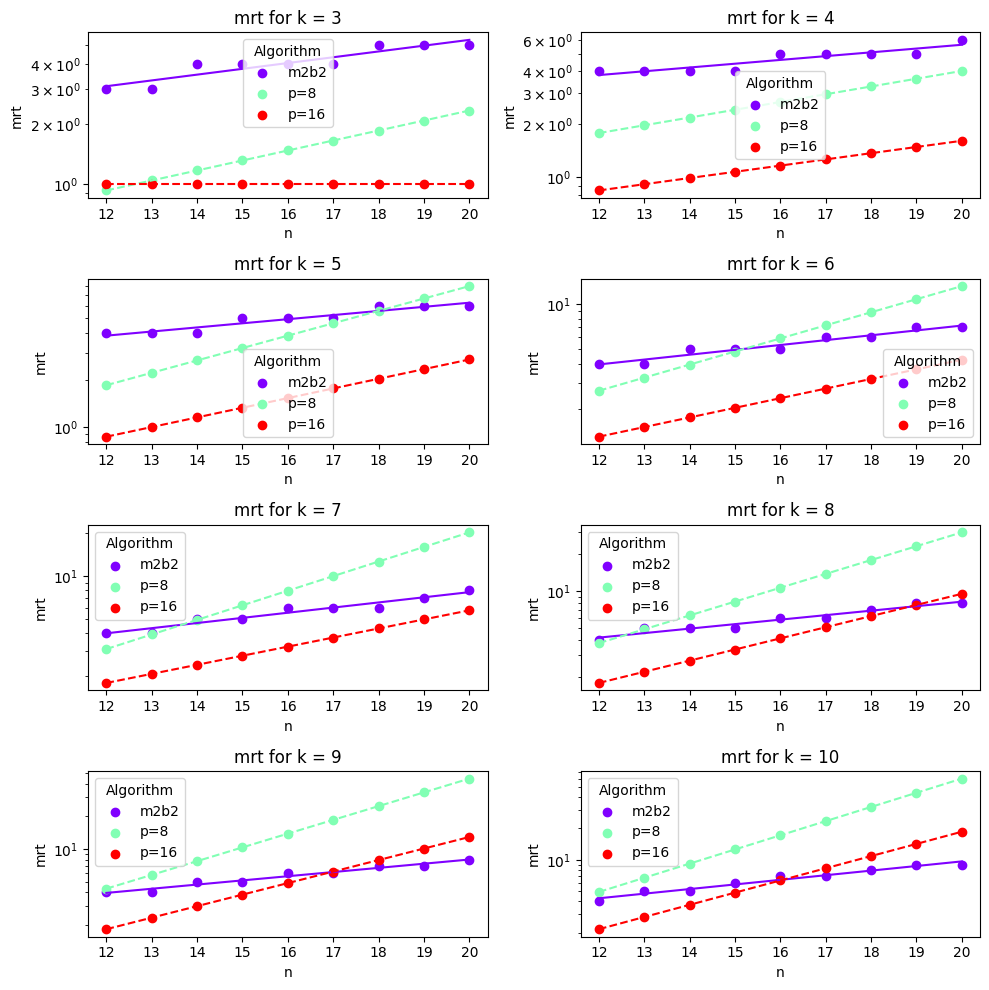

In [41]:
columns = 2
fig, axs = plt.subplots(len(ks) // columns, columns, figsize=(10, 10))
walksat_coeffs = {k : {} for k in ks}
for (ax, k) in zip(axs.flatten(), ks):
	mrt = mrts[k]

	x = list(mrt.keys())
	ys = [[mrt[n][tb] for n in x] for tb in tbs]
	color = iter(plt.cm.rainbow(np.linspace(0, 1, len(tbs) + len(ps))))

	for (tb, y) in zip(tbs, ys):
		c = next(color)
		# Points
		ax.scatter(x, y, label=tb, color=c)

		# Line of best fit
		fit = np.polyfit(x, np.log(y), 1, full=True)
		#print(f' WALKSAT coeff: {coefficients}, k = {k}')
		coefficients = fit[0]
		residuals = fit[1]
		walksat_coeffs[k]['c'] = list(coefficients)
		walksat_coeffs[k]['r'] = residuals
		polynomial = np.poly1d(coefficients)
		ax.plot(x, np.exp(polynomial(x)), color=c)

	# QAOA
	for p in ps:
		c = next(color)
		qaoa_c = qaoa_coeffs[k][p]
		#print(f' QAOA coeff: {qaoa_c}, k = {k}, p = {p}')
		qaoa_polynomial = np.poly1d(qaoa_c)
		ax.scatter(x, np.exp(qaoa_polynomial(x)), label=f'p={p}', color=c)
		ax.plot(x, np.exp(qaoa_polynomial(x)), linestyle='dashed', color=c)

	ax.set_yscale('log')
	ax.set_xlabel('n')
	ax.set_ylabel('mrt')
	ax.legend(title='Algorithm')
	ax.set_title(f'mrt for k = {k}')

fig.tight_layout()
plt.show()

In [78]:
qaoa_coeffs[8]

{1: {'c': [0.46642738978068055, -0.6574470837910992],
  'r': [0.003720524201738542]},
 2: {'c': [0.4053826967875165, -0.92737911542257],
  'r': [0.0015877207076604842]},
 4: {'c': [0.353478523095449, -1.29992329279582], 'r': [0.003934372128082003]},
 8: {'c': [0.32505629062652613, -1.7756256156497567],
  'r': [0.18070820756002814]},
 16: {'c': [0.30786333084106465, -2.0300384389029644],
  'r': [0.3130480231211913]}}

Plotting the coefficients:

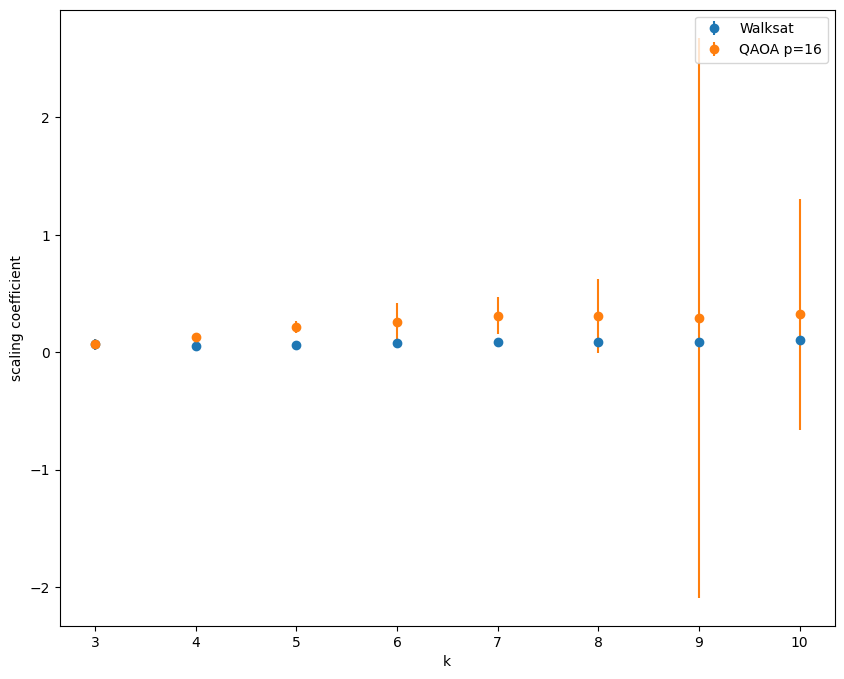

In [77]:
fig, ax = plt.subplots(figsize=(10, 8))
ws = [cs['c'][0] for cs in walksat_coeffs.values()]
wse = [cs['r'][0] for cs in walksat_coeffs.values()]
p8 = [ps[8]['c'][0] for ps in qaoa_coeffs.values()]
p8e = [ps[8]['r'][0] for ps in qaoa_coeffs.values()]
p16 = [ps[16]['c'][0] for ps in qaoa_coeffs.values()]
p16e = [ps[16]['r'][0] for ps in qaoa_coeffs.values()]
ax.errorbar(ks, ws, yerr=wse, label='Walksat', fmt='o')
#ax.errorbar(ks, p8, yerr=p8e, label='QAOA p=8', fmt='o')
ax.errorbar(ks, p16, yerr=p16e, label= 'QAOA p=16', fmt='o')
plt.legend()
plt.xlabel('k')
plt.ylabel('scaling coefficient')
plt.show()

Plotting the comparison of QAOA and WalkSAT for k-SAT:

In [166]:
import torch
import h5py
# Load, combine and calculate median running time from hdf5 files
num_proc = 10
batch_size = 250
ks = [8]
ns = [i for i in range(12, 21)]
parent_dir = os.path.dirname(os.getcwd())
dir = f"{parent_dir}/experiments/exp4/ksat"

mrts = {}
for k in ks:
	mrts[k] = {}
	for n in ns:
		# Initialise empty tensor for runtimes
		rt = torch.zeros(size=(num_proc * batch_size, ))
		for proc in range(num_proc):
			index = proc * batch_size
			filename = f'{dir}/res/rt_{n}_{k}_{index}.hdf5' 
			with h5py.File(filename, 'r') as file:
				fresh = torch.from_numpy(file.get('times')[:])
				rt[index : index + batch_size] = fresh
		mrts[k][n] = torch.median(rt)

In [167]:
# Coefficients for QAOA
with open(f'{dir}/coeffs.json', 'r') as f:
    qaoa_coeffs = json.load(f)
    qaoa_coeffs = {int(k) : {int(p) : np.array(c) for (p, c) in coeffs.items()} for (k, coeffs) in qaoa_coeffs.items()}

[0.2119994  2.16782929]
[ 0.26823033 -1.38894832]
[ 0.22625769 -1.72401084]


<Figure size 1500x1000 with 0 Axes>

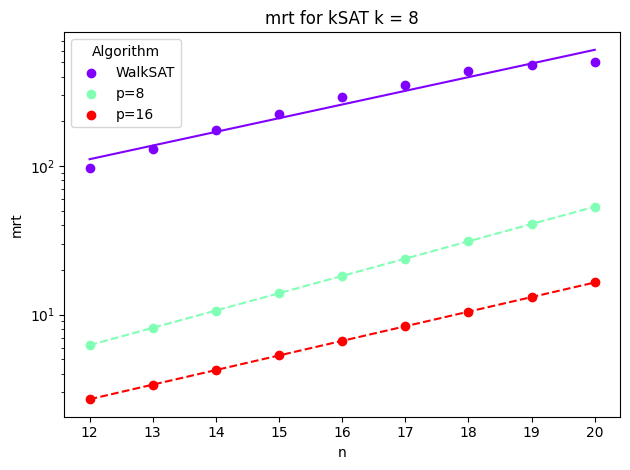

In [191]:
plt.figure(figsize=(15, 10))
fig, ax = plt.subplots()
mrt = mrts[k]

xs = list(mrt.keys())
ys = [mrt[n] for n in x]
color = iter(plt.cm.rainbow(np.linspace(0, 1, 1 + len(ps))))

c = next(color)
# Points
ax.scatter(xs, ys, label='WalkSAT', color=c)

# Line of best fit
coefficients = np.polyfit(xs, np.log(ys), 1)
print(coefficients)
polynomial = np.poly1d(coefficients)
ax.plot(xs, np.exp(polynomial(xs)), color=c)

# QAOA
for p in ps:
	c = next(color)
	qaoa_polynomial = np.poly1d(qaoa_coeffs[k][p])
	print(qaoa_coeffs[k][p])
	ax.scatter(xs, np.exp(qaoa_polynomial(xs)), label=f'p={p}', color=c)
	ax.plot(xs, np.exp(qaoa_polynomial(xs)), linestyle='dashed', color=c)

ax.set_yscale('log')
ax.set_xlabel('n')
ax.set_ylabel('mrt')
ax.legend(title='Algorithm')
ax.set_title(f'mrt for kSAT k = {k}')

fig.tight_layout()
plt.show()